In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def hkl1(const):
    from math import sqrt
    
    for h in range(51):
        
        if h ** 2 > const:
            raise ValueError('h^2 > const; couldn\'t find an appropriate Miller plane')
        
        for k in range(51):
            
            if k ** 2 > const:
                break
            
            l = sqrt(const - h ** 2 - k ** 2)
            
            if l % 1 == 0:
                
                temp = [h, k, int(l)]
                temp.sort(reverse=True)
                
                return np.array(temp)

In [3]:
def hkl(arr):
    
    miller = []
    
    #Obtain the set of Miller planes for every Bragg peak
    for i, const in enumerate(arr):
        miller.append(hkl1(const) )
    
    miller = np.array(miller)
    labels = miller.astype(np.str_)
    labels = [''.join(i).join( ('{', '}') ) for i in labels]
    
    return miller, labels

In [4]:
def plot_data(dd, const):
    from numpy.polynomial import Polynomial as P
    from numpy.polynomial.polynomial import polyfit
    import matplotlib.pyplot as plt
    
    a = polyfit(const, dd, 1)[1]
    
    bestfit = P.fit(const, dd, 1)
    x, y = bestfit.linspace(domain=[0, bestfit.domain[1]])
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.scatter(const, dd, label='actual data')
    ax.plot(x, y, label='line of best fit')
    
    ax.set_xlim(0)
    ax.set_ylim(0)
    
    ax.set_xlabel(r'$h^{2}$ +' + r' $k^{2}$ +' + r' $l^{2}$', fontsize=15)
    ax.set_ylabel(r'$\frac{1}{d^{2}}$  /$\frac{1}{Å^2}$', fontsize=15)
    
    plt.legend(fontsize=15)
    
    plt.show()
    
    return a

In [145]:
def analyse_diffraction(data, lamda, angle=2, **kwargs):
    """
    Given the angles from diffraction experiment, indexes the results, determines the unit Bravais lattice and 
    calculates unit cell length.
    
    Parameters
    ----------
    data : str or array_like
        Input data - θ values of Bragg peaks
    lamda : float or int
        The wavelength of the x-ray used in the scattering experiment.
        Must be in units of nm
    angle : int or float, optional
        The multiplier of the inputted θ values; if data is not the scattering angle but its multiple,
        angle will be used to divide the inputted data so as to obtain the true scattering angle θ.
        Default = 2, i.e. the default data is as 2θ.
    kwargs : chemical symbol of element = int
        Used to check if the atoms in the solid are close in atomic number or if the ions in the solid are
        isoelectronic. In those cases, normal x-ray scattering experiments are not precise enough to distinguish
        the atoms, so a warning is issues that the predicted unit cell may not be correct.
    
    Returns
    -------
    - calculated unit cell
    - warning if appropriate (see kwargs)
    - plot of 1/d**2 against plane parameters
    - unit cell length
    df : Pandas DataFrame containing the indexing
    """
    from math import sqrt
    from itertools import combinations
    
    from SigFigRounding import RoundToSigFigs_fp

    
    #first change data into a usable format
    if type(data) is str:
        
        if data.find('\n') != -1: #deal with data in separate lines
            data = data.splitlines()
            data = np.array([float(i.replace(',', '').strip()) for i in data])
            
        else: #deal with data separated by unknown numbers of spaces
            data = data.replace(',', '').replace(';', '').split(' ')
            data = np.array(list(filter(lambda x: x != ' ', data) ))
            data = data[data != ''].astype(float)
            
    
    else:
        data = np.array(data)
    
    
    #decimals = len(str(lamda).split('.')[1]) 
    decimals = (max([len(str(lamda) ), len(str(data[0]) ) ] ) - 1)#determine the number of significant figures
        #this will be used to round the resuls of each calculation to an appropriate number of
        #significant figures so as to maintain a consistent degree of accuracy.
    
    
    d = RoundToSigFigs_fp(lamda / (2 * np.sin(np.radians(data / angle) ) ), decimals) #obtain d using Bragg equation
    cubicd = RoundToSigFigs_fp(1 / d ** 2, decimals) #assume the unit cell is cubic
    const = RoundToSigFigs_fp(cubicd / np.amin(cubicd), 3) #divide all values by the smallest to eliminate a
    
    
    
    #Names for dataframe columns
    name_d2 = r'$$\frac{1}{d^{2}}  /\frac{1}{Å^2}$$'
    name_hkl = r'$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$'
    name_const = r'$$\frac{1}{d^2} /$$' + f'{np.amin(cubicd)}'
    
    #If h2 + k2 + l2 = integer, prcoeed as-is; if not, try to find an integer that will mutliple the const so that it
    ##becomes an integer
    if (np.absolute(const - np.round(const))  <= 0.05).all():
        
        const2 = np.round(const).astype(np.int64)
        miller, labels = hkl(const2) #obtain miller planes
        
        df =  pd.DataFrame({'2θ': data, 'd /Å': d, name_d2: cubicd, name_const: const, 
                            name_hkl: const2, 'Index': labels})
        
    else:
        
        #look for an integer i such that i * const = integer
        for i in range(2, 101):
            
            const2 = const * i
            if (np.absolute(const2 - np.round(const2))  < 0.05).all():
                multiplier = i
                break
        
        const3 = np.round(const2).astype(np.int64)
        miller, labels = hkl(const3) #obtain Miller planes
        
        df =  pd.DataFrame({'2θ': data, 'd /Å': d, name_d2: cubicd, name_const: const, 
                            (name_const + f' × {multiplier}'): const2, name_hkl: const3, 'Index': labels})
        
        const = const2 #bring the actual value to array of name consistent with the other option
    
    
    
    if np.array([(i % 2 == 0 ).all() or (i % 2 == 1).all() for i in miller]).all() == True:
        #Material is fcc if each set of h, k, l is all odd or all even.
        print('This material has a face-centered cubic unit cell since hkl are either all even or all odd.')
    
    elif (np.sum(miller, axis=1) % 2 == 0).all() == True:
        #Material is bcc if the sum of each set of h, k, l is an even number.
        print('This material has a body-centered cubic unit cell since h+k+l is always even.')
    
    else:
        print('This material has a primitive cubic unit cell since all possible Miller planes are present.')
          
    
    a = plot_data(cubicd, const)
    print('1/a2 = ',  RoundToSigFigs_fp(a, decimals), ' Å')
    print('a = ', RoundToSigFigs_fp(sqrt(a ** -1), decimals), ' Å')
    
    return df

This material has a face-centered cubic unit cell.


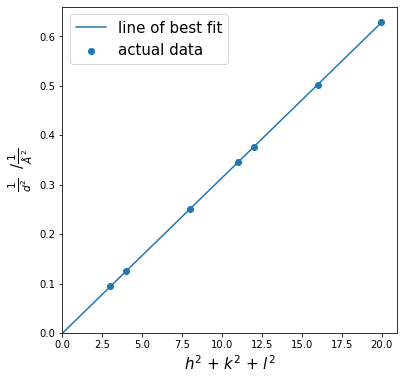

a =  5.642  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /const$$,$$\frac{1}{d^2} /constant$$,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,27.38,3.257,0.09427,1.00,3.00,3,{111}
1,31.72,2.821,0.12570,1.33,3.99,4,{200}
2,45.47,1.995,0.25130,2.67,8.01,8,{220}
3,53.89,1.701,0.34560,3.67,11.01,11,{311}
4,56.50,1.629,0.37680,4.00,12.00,12,{222}
5,66.26,1.411,0.50230,5.33,15.99,16,{400}
6,75.33,1.262,0.62790,6.66,19.98,20,{420}


In [6]:
analyse_diffraction([27.38, 31.72, 45.47, 53.89, 56.50, 66.26, 75.33], 1.5418, Na=1, Cl=-1)

This material has a primitive cubic unit cell.
However, Potassium and Chlorine have similar number of electrons, and therefore due to limitations of X-ray diffraction, the two atoms are indistinguishable. If that is the case, the returned unit cell is more symmetric than the actual unit cell of the material.


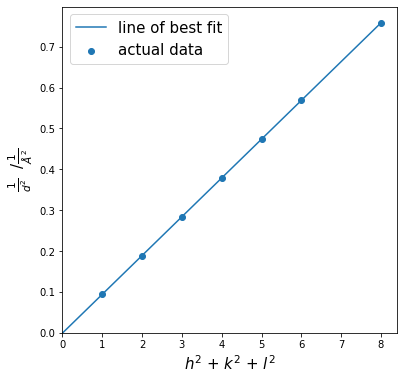

a =  3.249  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /const$$,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,27.46,3.248,0.09479,1.00,1,{100}
1,39.22,2.297,0.18950,2.00,2,{110}
2,48.54,1.875,0.28440,3.00,3,{111}
3,56.68,1.624,0.37920,4.00,4,{200}
4,64.10,1.453,0.47370,5.00,5,{210}
5,71.09,1.326,0.56870,6.00,6,{211}
6,84.33,1.148,0.75880,8.01,8,{220}


In [7]:
analyse_diffraction([27.46,   39.22,   48.54,   56.68,   64.10,   71.09,   84.33], 1.5418, K=1, Cl=-1)

This material has a primitive cubic unit cell.


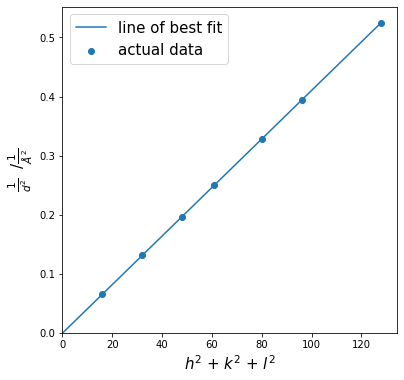

a =  15.61  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /const$$,$$\frac{1}{d^2} /constant$$,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,22.783,3.903,0.06565,1.00,16.00,16,{400}
1,32.440,2.760,0.13130,2.00,32.00,32,{440}
2,40.010,2.253,0.19700,3.00,48.00,48,{444}
3,45.353,2.000,0.25000,3.81,60.96,61,{650}
4,52.419,1.745,0.32840,5.00,80.00,80,{840}
5,57.865,1.593,0.39410,6.00,96.00,96,{844}
6,67.925,1.380,0.52510,8.00,128.00,128,{880}


In [8]:
analyse_diffraction([22.783,   32.44,   40.01,   45.353,   52.419,   57.865,   67.925], 1.5418)

This material has a primitive cubic unit cell.
However, Copper and Zinc have similar number of electrons, and therefore due to limitations of X-ray diffraction, the two atoms are indistinguishable. If that is the case, the returned unit cell is more symmetric than the actual unit cell of the material.


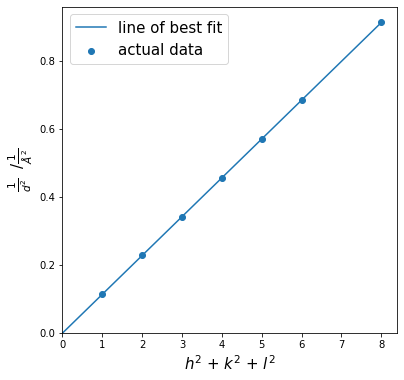

a =  2.9591  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /const$$,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,31.472,2.9590,0.11421,1.0,1,{100}
1,45.107,2.0923,0.22843,2.0,2,{110}
2,56.035,1.7084,0.34263,3.0,3,{111}
3,65.696,1.4795,0.45685,4.0,4,{200}
4,74.665,1.3233,0.57106,5.0,5,{210}
5,83.260,1.2080,0.68528,6.0,6,{211}
6,100.186,1.0462,0.91363,8.0,8,{220}


In [109]:
analyse_diffraction([31.472,  45.107,  56.035,  65.696,  74.665,  83.260,  100.186],  1.605, Cu=0, Zn=0)

This material has a primitive cubic unit cell.


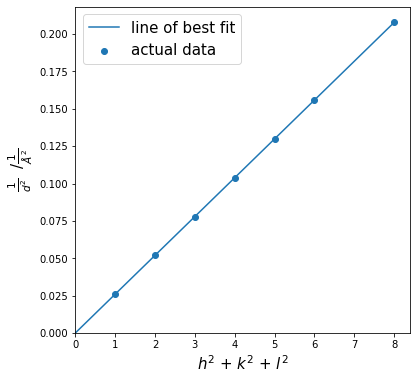

a =  6.207  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /const$$,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,14.26,6.206,0.02596,1.0,1,{100}
1,20.22,4.388,0.05194,2.0,2,{110}
2,24.83,3.583,0.07789,3.0,3,{111}
3,28.75,3.103,0.10390,4.0,4,{200}
4,32.23,2.775,0.12990,5.0,5,{210}
5,35.40,2.534,0.15570,6.0,6,{211}
6,41.11,2.194,0.20770,8.0,8,{220}


In [10]:
analyse_diffraction([14.26, 20.22, 24.83, 28.75, 32.23, 35.40, 41.11], 1.5406)

This material has a face-centered cubic unit cell.
However, Potassium and Sulfur have similar number of electrons, and therefore due to limitations of X-ray diffraction, the two atoms are indistinguishable. If that is the case, the returned unit cell is more symmetric than the actual unit cell of the material.


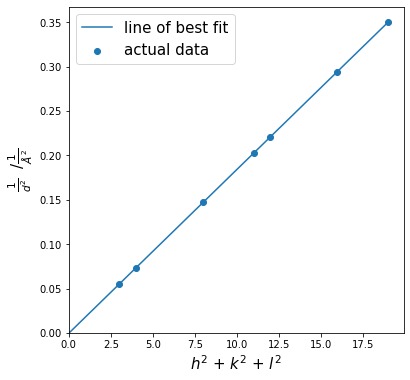

a =  7.3683  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /const$$,$$\frac{1}{d^2} /constant$$,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,20.860,4.2550,0.055233,1.00,3.00,3,{111}
1,24.132,3.6850,0.073642,1.33,3.99,4,{200}
2,34.390,2.6057,0.147280,2.67,8.01,8,{220}
3,40.565,2.2221,0.202520,3.67,11.01,11,{311}
4,42.454,2.1275,0.220930,4.00,12.00,12,{222}
5,49.426,1.8425,0.294570,5.33,15.99,16,{400}
6,54.205,1.6908,0.349800,6.33,18.99,19,{331}


In [137]:
analyse_diffraction('20.860;   24.132;   34.390;   40.565;   42.454;   49.426;   54.205',  1.5406, K=1, S=-2)

This material has a primitive cubic unit cell since all possible Miller planes are present.


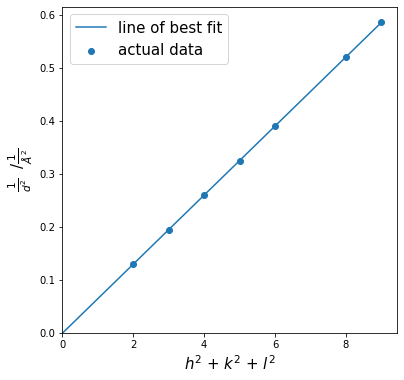

1/a2 =  0.0650859  Å
a =  3.91973  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /$$0.130162,$$\frac{1}{d^2} /$$0.130162 × 2,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,32.27,2.77177,0.130162,1.0,2.0,2,{110}
1,39.80,2.26300,0.195268,1.5,3.0,3,{111}
2,46.28,1.96010,0.260282,2.0,4.0,4,{200}
3,52.13,1.75306,0.325392,2.5,5.0,5,{210}
4,57.55,1.60018,0.390537,3.0,6.0,6,{211}
5,67.53,1.38592,0.520623,4.0,8.0,8,{220}
6,72.25,1.30656,0.585789,4.5,9.0,9,{300}


In [146]:
analyse_diffraction('32.27  39.80    46.28 52.13    57.55  67.53   72.25',  1.54056)

In [150]:
def generate_peaks(a, lamda, c=0, bravais='p'):
    """
    Predict the peaks of a solid given the lattice parameters and wavelength.
    
    Parameters
    ----------
    a : float
        cell parameter
    lamda : float
        wavelength of the light used to perform the diffraction experiment
    c : float, optional
        the distorted cell parameter, default is zero, implying cubic unit cell
    bravais : str, optional
        type of Bravais lattice (primitive (p), face-centered (f), or body-centered (i))
        default is primitive (p)
    
    Returns
    -------
    - indexing table prediciting the X-ray diffraction peaks
    """
    from SigFigRounding import RoundToSigFigs_fp
    
    decimals = (max([len(str(lamda) ), len(str(a) ), len(str(c)) ] ) - 1) #number of significant figures
    
    if c == 0: #if the Bravais lattice is cubic
        
        #first 10 relevant Miller planes
        if bravais[0].lower() == 'p': #primitive cubic Bravais lattice
            hkl = np.array([[1, 1, 1, 2, 2, 2, 2, 2, 3, 3],
                        [0, 1, 1, 0, 1, 1, 2, 2, 1, 1],
                        [0, 0, 1, 0, 0, 1, 0, 1, 0, 1]]).T
            
        elif bravais[0].lower() == 'f': #face-centered cubic Bravais lattice
            hkl = np.array([[1, 2, 2, 3, 2, 4, 4, 3, 4, 3],
                        [1, 0, 2, 1, 2, 0, 2, 3, 2, 3],
                        [1, 0, 0, 1, 2, 0, 0, 1, 2, 3]]).T
            
        elif bravais[0].lower() == 'i': #body-centered  cubic Bravais lattice
            hkl = np.array([[1, 2, 2, 2, 3, 2, 3, 4, 4, 4],
                        [1, 0, 1, 2, 1, 2, 2, 0, 1, 2],
                        [0, 0, 1, 0, 0, 2, 1, 0, 1, 0]]).T
        else:
            raise ValueError('Parameter bravais must have a value of p, f or i.')
        
        hkls = hkl[:, 0] ** 2 + hkl[:, 1] ** 2 + hkl[:, 2] ** 2 #h^2 + k^2 + l^2
        dd = RoundToSigFigs_fp(hkls / a ** 2, decimals) #1/d^2
        
        #order the indexing by increasing 1/d^2 and therefore increasing angle
        ordered = np.argsort(dd)
        dd = dd[ordered]
        hkl = hkl[ordered]
        hkls = hkls[ordered]
        
    
    else:
        hkl = np.array([[1, 0, 1, 1, 1, 2, 0, 2, 2, 2], #first 10 Miller plane sets
                        [0, 0, 1, 0, 1, 0, 0, 1, 0, 1],
                        [0, 1, 0, 1, 1, 0, 2, 0, 1, 1]]).T
        
        #1/d^2:
        dd = RoundToSigFigs_fp((hkl[:, 0] ** 2 + hkl[:, 1] ** 2) / a ** 2 + hkl[:, 2] ** 2 / c ** 2, decimals)
        
        #order the indexing by increasing 1/d^2 and therefore increasing angle
        ordered = np.argsort(dd)
        dd = dd[ordered]
        hkl = hkl[ordered]
        
        
    d = RoundToSigFigs_fp(np.sqrt(1 / dd), decimals) #d
    sintheta = RoundToSigFigs_fp(lamda / (2 * d), decimals) #sin θ
    theta = RoundToSigFigs_fp(2 * np.degrees(np.arcsin(sintheta) ), decimals) #2θ
    
    name1 = r'$$\frac{1}{d^{2}}  /\frac{1}{Å^2}$$'
    
    df = pd.DataFrame({'h': hkl[:, 0], 'k': hkl[:, 1], 'l': hkl[:, 2], 
                       name1: dd, 'd /Å': d, 'sin θ': sintheta, '2θ': theta})
    
    
    if c is None: #add an hkl column for cubic Bravais lattice
        name2 = r'$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$'
        df.insert(3, name2, hkls)
    
    return df

In [100]:
generate_peaks(9.801, 0.7, bravais='f')

,h,k,l,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,d /Å,sin θ,2θ
0,1,1,1,3,0.031231,5.658610,0.061853,7.09
1,2,0,0,4,0.041641,4.900500,0.071421,8.19
2,2,2,0,8,0.083282,3.465177,0.101005,11.59
3,3,1,1,11,0.114512,2.955113,0.118439,13.60
4,2,2,2,12,0.124922,2.829305,0.123705,14.21
5,4,0,0,16,0.166563,2.450250,0.142843,16.42
6,3,3,1,19,0.197794,2.248504,0.155659,17.91
7,4,2,0,20,0.208204,2.191570,0.159703,18.38
8,4,2,2,24,0.249845,2.000621,0.174946,20.15
9,3,3,3,27,0.281075,1.886203,0.185558,21.39


In [151]:
generate_peaks(3.7732, 1.2, 5.5250, bravais='f')

,h,k,l,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,d /Å,sin θ,2θ
0,0,0,1,0.032759,5.5250,0.10860,12.469
1,1,0,0,0.070239,3.7732,0.15902,18.300
2,1,0,1,0.103000,3.1159,0.19256,22.204
3,0,0,2,0.131040,2.7625,0.21719,25.088
4,1,1,0,0.140480,2.6680,0.22489,25.993
5,1,1,1,0.173240,2.4026,0.24973,28.923
6,2,0,0,0.280960,1.8866,0.31803,37.088
7,2,0,1,0.313720,1.7854,0.33606,39.274
8,2,1,0,0.351200,1.6874,0.35558,41.658
9,2,1,1,0.383960,1.6138,0.37179,43.652
